### This is a script that analyze time-series data using correlation and hierarchical clustering

In [1]:
%matplotlib inline

import sys
sys.path.append('../python/')

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import imp
# import cdr
import json
import os.path
from scipy.spatial.distance import cosine
from pandas.io.json import json_normalize
from scipy.spatial import distance
# imp.reload(cdr)
import numpy as np
import fastcluster as fc
from scipy.cluster.hierarchy import fcluster
from pylab import *
from sklearn.metrics import mean_squared_error

from scipy.cluster import hierarchy

print ("Libraries loaded")



Libraries loaded


In [2]:
cdr = pd.read_csv('../../data/CDR/hash/0727_region_time.csv')
# cdr.head()
# cdr = cdr[['adjusted_callIn', 'adjusted_callOut', 'adjusted_internet', 'adjusted_smsIn', 'adjusted_smsOut', 'region_id', 'unique_time']]

In [3]:
def show_clustermap(cdr, values):
    call = cdr.pivot(index='region_id', columns='unique_time', values=values)
    call.fillna(0, inplace=True)
    x = call.as_matrix()
    mean = np.mean(call, 0)

    x_prime = np.zeros(shape=(85,mean.count()))

    for i in range(0, 85):
        x_prime[i] = x[i] - mean

    x_prime = np.transpose(x_prime)
    xpp = pd.DataFrame(x_prime)

    corr = xpp.corr()
    correlations_array = np.asarray(corr)

    row_linkage = hierarchy.linkage(
        distance.pdist(correlations_array), method='average')

    col_linkage = hierarchy.linkage(
        distance.pdist(correlations_array.T), method='average')

    sns.clustermap(corr, row_linkage=row_linkage, col_linkage=col_linkage, method="average",
                   figsize=(13, 13))
    return xpp, corr, row_linkage, mean

def get_half_linkage(cdr, values):
    call = cdr.pivot(index='region_id', columns='unique_time', values=values)
    call.fillna(0, inplace=True)
    x = call.as_matrix()
    mean = np.mean(call, 0)

    x_prime = np.zeros(shape=(85,mean.count()))

    for i in range(0, 85):
        x_prime[i] = x[i] - mean

    x_prime = np.transpose(x_prime)
    xpp = pd.DataFrame(x_prime)
    xpp = xpp.T    
    xpp_first = xpp[xpp.columns[0:1464/2]]
    xpp_second = xpp[xpp.columns[1464/2:1464]]    

    corr = xpp_first.T.corr()
    correlations_array = np.asarray(xpp_first.T)

    row_linkage = hierarchy.linkage(
        distance.pdist(correlations_array.T), method='average')

    return xpp_second, corr, row_linkage, mean

## Calculating RMSEs to determine the number of clusters

In [4]:
def plot_rmse(call_type):
    xpp, corr, linkage, mean = get_half_linkage(cdr, call_type)
    rms_table = pd.DataFrame(columns=['num_cluster', 'RMSE'])
    xpp.index = xpp.index + 1

    for i in range(1, 15):
        cdrr = fcluster(linkage, i, criterion='maxclust')
        cdrr = pd.DataFrame(cdrr, columns=['cluster'])
        cdrr.index = cdrr.index + 1
        cdrr['region'] = cdrr.index
        cdrr.index = cdrr.cluster
        avg_rms = np.empty(shape=[0])

        for k in range(1, i+1):           
            subset = xpp[xpp.index.isin(cdrr.region[cdrr.index == k])]                         
            rmse = 0
            mean = subset.mean()

            for index, row in subset.iterrows():
                rmse += np.sqrt(mean_squared_error(mean, row))

            rmse = rmse/len(subset)
            avg_rms = np.append(avg_rms, [rmse])        

        rms_table.loc[i] = [int(i), avg_rms.mean()]


    x_range = 10

    fig = plt.figure(figsize=(30,20))
    ax = fig.add_subplot(1,1,1)
    major_ticks = np.arange(0, x_range, 1)      
    minor_ticks = np.arange(0, x_range, 1) 
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)  

    # and a corresponding grid             
    ax.grid(which='both')
    ax.axis([0, x_range , 0, 3000])
    ax.plot(rms_table['RMSE'], label="RMSE")
    ax.legend(prop={'size':40})
    ax.set_ylabel('RMSE', fontsize=40)
    ax.set_xlabel('Number of Clusters', fontsize=40)
    ax.tick_params(axis='both', which='major', labelsize=40)

In [28]:
# plot_rmse("adjusted_internet")

In [29]:
# plot_rmse("adjusted_callIn")
# plot_rmse("adjusted_callOut")

In [30]:
# plot_rmse("adjusted_smsIn")
# plot_rmse("adjusted_smsOut")

In [8]:
num_cluster = 3

## Distances to Cluster Centroids as Features

In [44]:
def calculate_distances(call_type):
    call = cdr.pivot(index='region_id', columns='unique_time', values=call_type)
    call.fillna(0, inplace=True)
    x = call.as_matrix()
    mean = np.mean(call, 0)
    x_prime = np.zeros(shape=(85,mean.count()))

    for i in range(0, 85):
        x_prime[i] = x[i] - mean

    xpp = pd.DataFrame(x_prime)
    xpp.index = xpp.index + 1

    cluster_table = pd.read_csv("cluster_analysis.csv")

    # for index, row in xpp.iterrows(): 
    mean = {}
    distances = pd.DataFrame(columns=["c1", "c2", "c3"])

    #Centroids
    for k in range (1, num_cluster+1):
        subset = xpp[xpp.index.isin(cluster_table.region[cluster_table.internet == k])]                         
        mean[k] = subset.mean()

    for index, row in xpp.iterrows():
        distances.loc[index] = [np.linalg.norm(row-mean[1]),np.linalg.norm(row-mean[2]),np.linalg.norm(row-mean[3])]

    distances.to_csv("../../data/CDR/generated/" + call_type + "_dist.csv")
    return 

In [46]:
calculate_distances("adjusted_internet")
calculate_distances("adjusted_callIn")
calculate_distances("adjusted_callOut")
calculate_distances("adjusted_smsIn")
calculate_distances("adjusted_smsOut")

In [23]:
def draw_time_series(xpp, corr, linkage, x_range, file_name, min_y, max_y):
    xpp = xpp.T
    xpp.index = xpp.index + 1

    cdrr = fcluster(linkage, num_cluster, criterion='maxclust')
    cdrr = pd.DataFrame(cdrr, columns=['cluster'])
    cdrr.index = cdrr.index + 1
    cdrr['region'] = cdrr.index
    
#     cdrr.to_csv(file_name + "_cluster.csv")
    
    cdrr.index = cdrr.cluster    

    cluster1 = xpp[xpp.index.isin(cdrr.region[cdrr.index == 1])].mean()
    cluster2 = xpp[xpp.index.isin(cdrr.region[cdrr.index == 2])].mean()
    cluster3 = xpp[xpp.index.isin(cdrr.region[cdrr.index == 3])].mean()
#     cluster4 = xpp[xpp.index.isin(cdrr.region[cdrr.index == 4])].mean()
#     cluster5 = xpp[xpp.index.isin(cdrr.region[cdrr.index == 5])].mean()
#     cluster6 = xpp[xpp.index.isin(cdrr.region[cdrr.index == 6])].mean()
    
    #GRAPHE
    fig = plt.figure(figsize=(60,15))
    ax = fig.add_subplot(1,1,1)
    major_ticks = np.arange(0, x_range, 24)                                              
    minor_ticks = np.arange(0, x_range, 4) 
    ax.set_xticks(major_ticks)                                                       
    ax.set_xticks(minor_ticks, minor=True)                                                                                    

    # and a corresponding grid                                                       

    ax.grid(which='both')                                                            

    ax.axis([0, x_range , min_y, max_y])

    ax.plot(cluster1, label="c1")
    ax.plot(cluster2, label="c2")
    ax.plot(cluster3, label="c3")
#     ax.plot(cluster4, label="c4")
#     ax.plot(cluster5, label="c5")
#     ax.plot(cluster6, ls = '--',label="c6")
    ax.legend(prop={'size':20})
    
    fig.savefig(file_name)
    return cdrr

# INTERNET

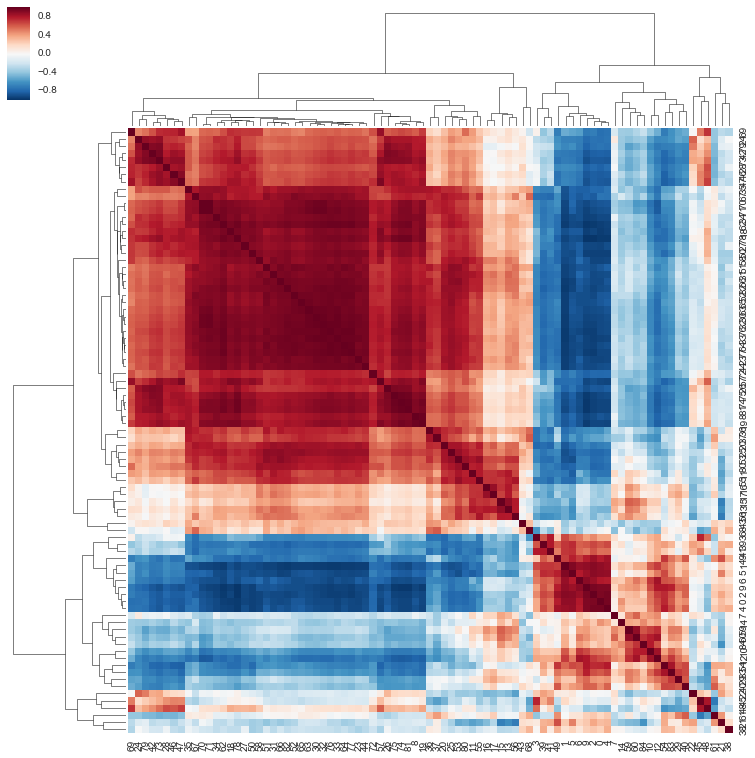

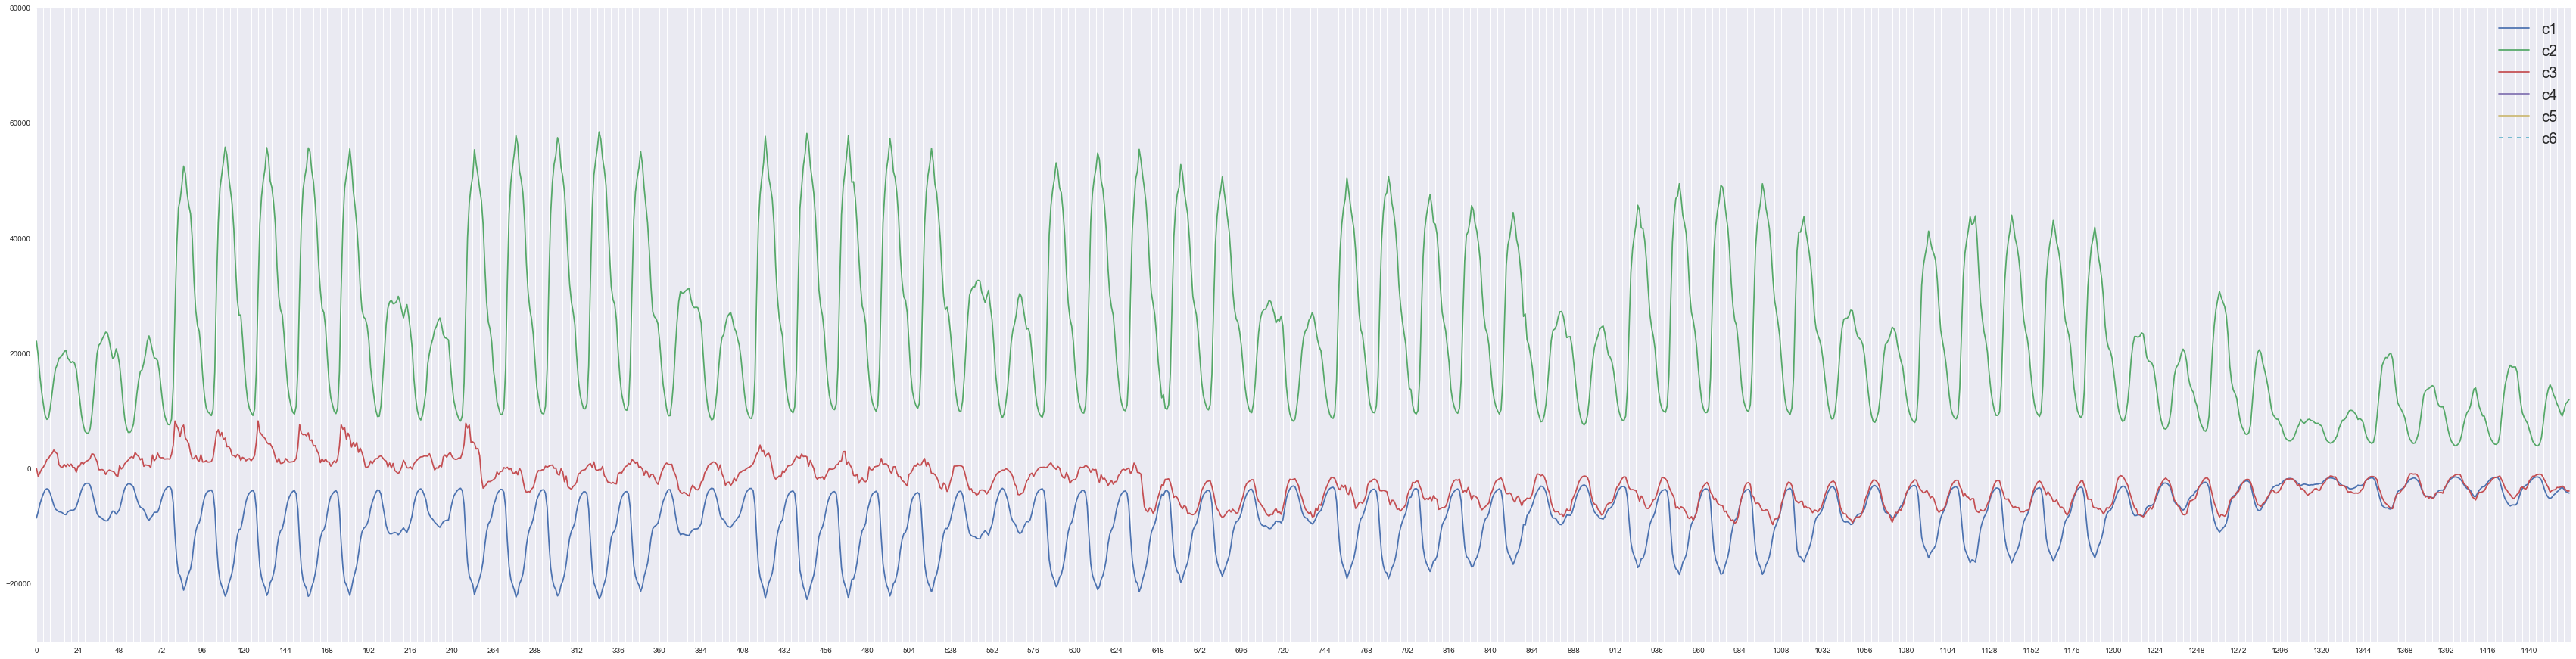

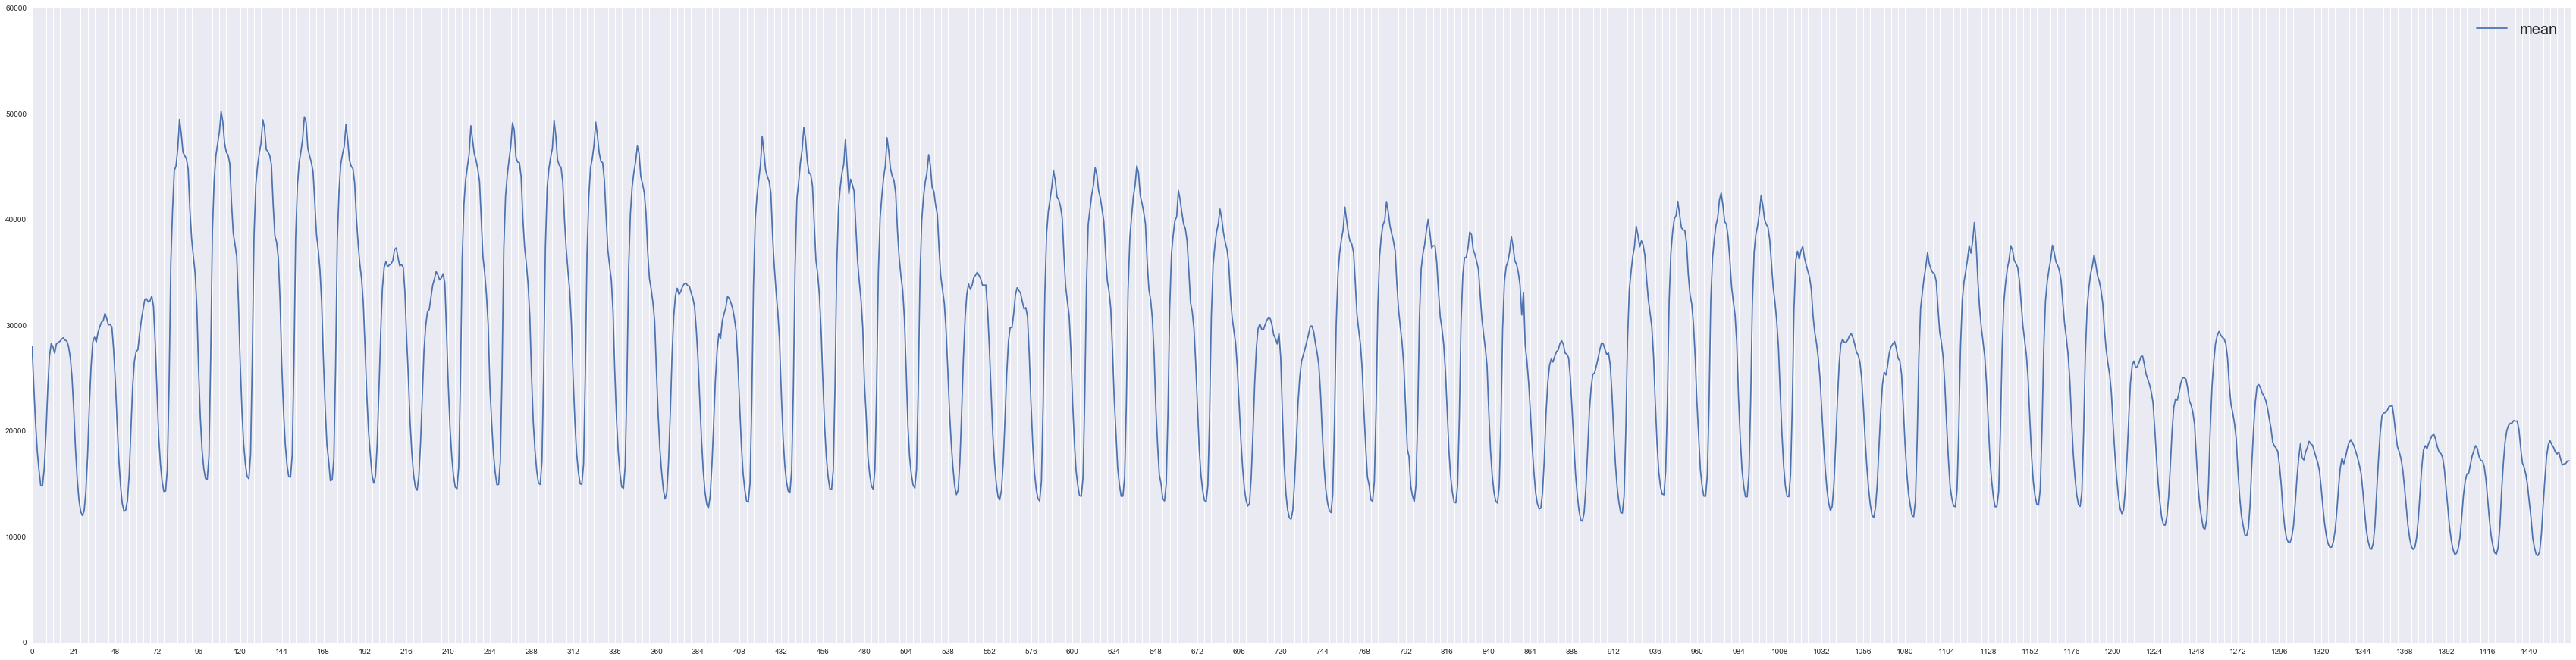

In [10]:
xpp, corr, linkage, mean = show_clustermap(cdr, "adjusted_internet")
internet = draw_time_series(xpp, corr, linkage, 24*61, "internet_graph.png", -30000, 80000)

m = pd.DataFrame(mean)
m.index = range(0,1464)

x_range = 24*61

fig = plt.figure(figsize=(60,15))
ax = fig.add_subplot(1,1,1)
major_ticks = np.arange(0, x_range, 24)                                              
minor_ticks = np.arange(0, x_range, 4) 
ax.set_xticks(major_ticks)                                                       
ax.set_xticks(minor_ticks, minor=True)                                           
                                       

# and a corresponding grid             
ax.grid(which='both')
ax.axis([0, x_range , 0, 60000])
ax.plot(m, label="mean")
ax.legend(prop={'size':20})

fig.savefig('mean_internet.png')

# CALL IN

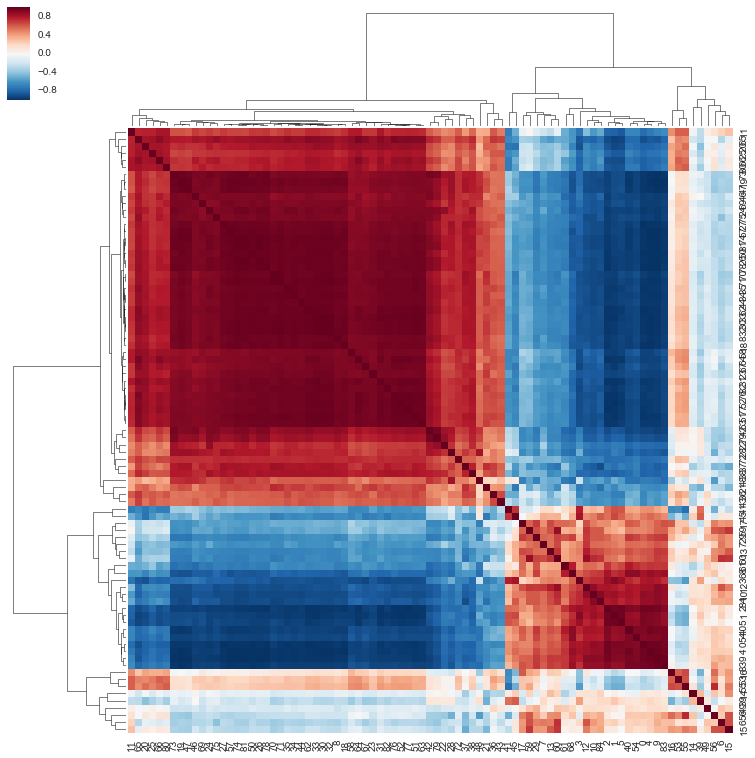

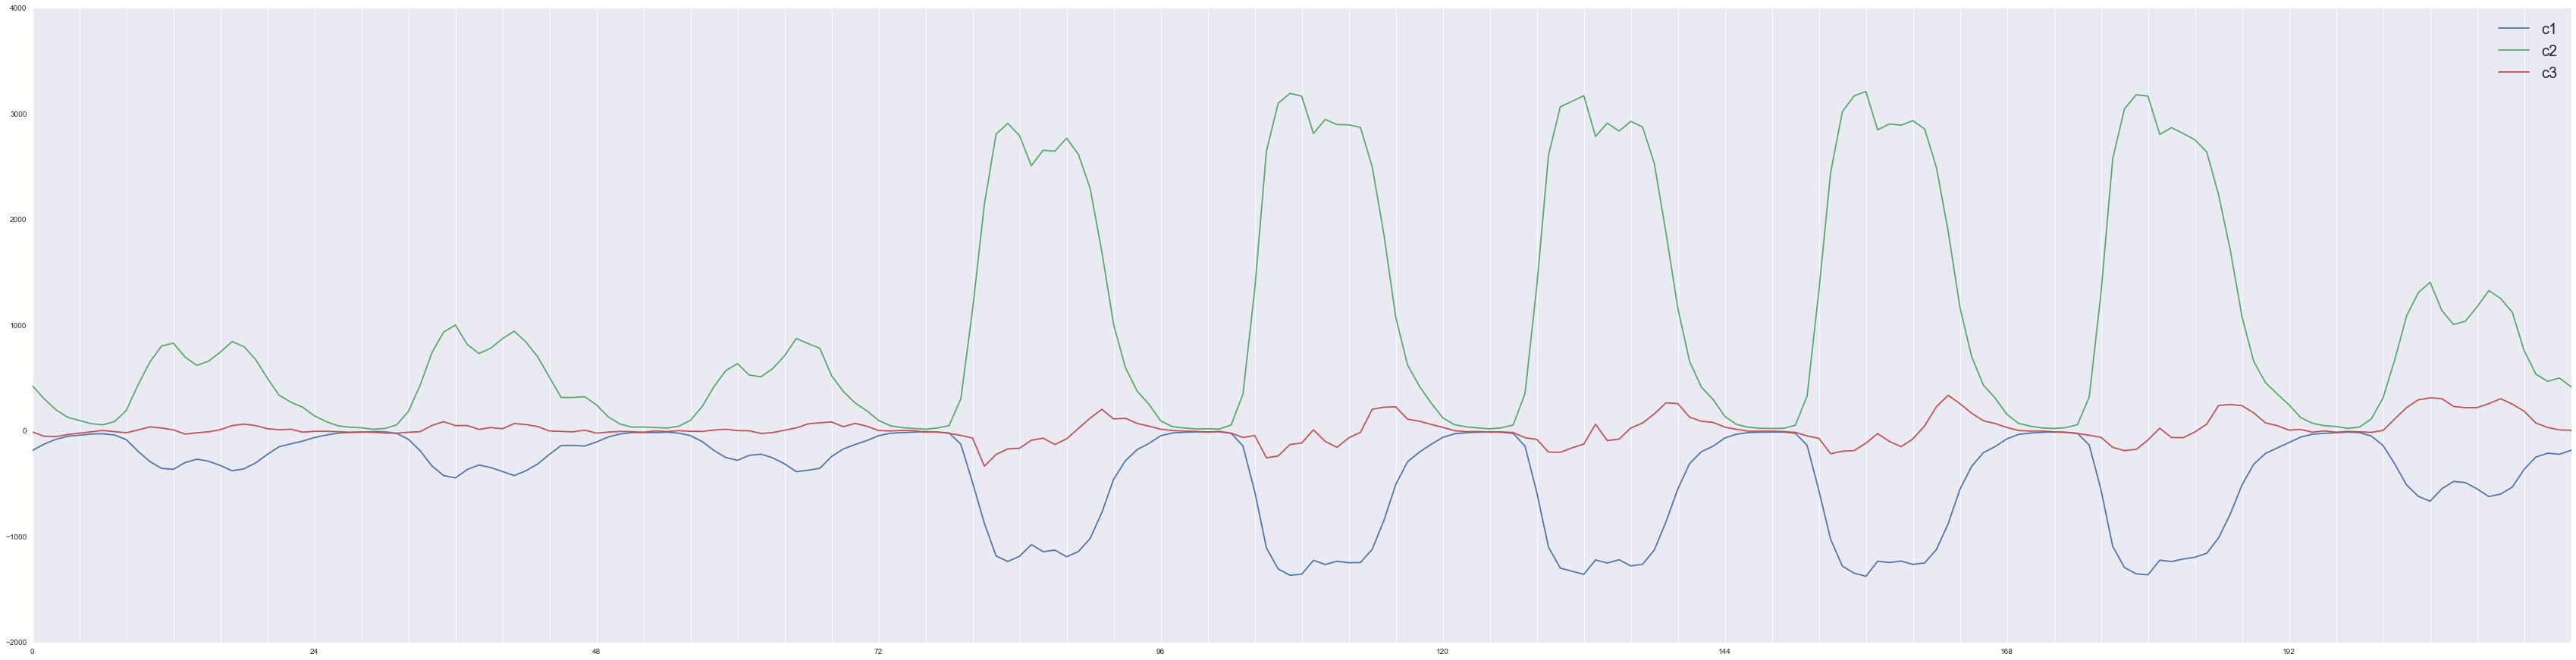

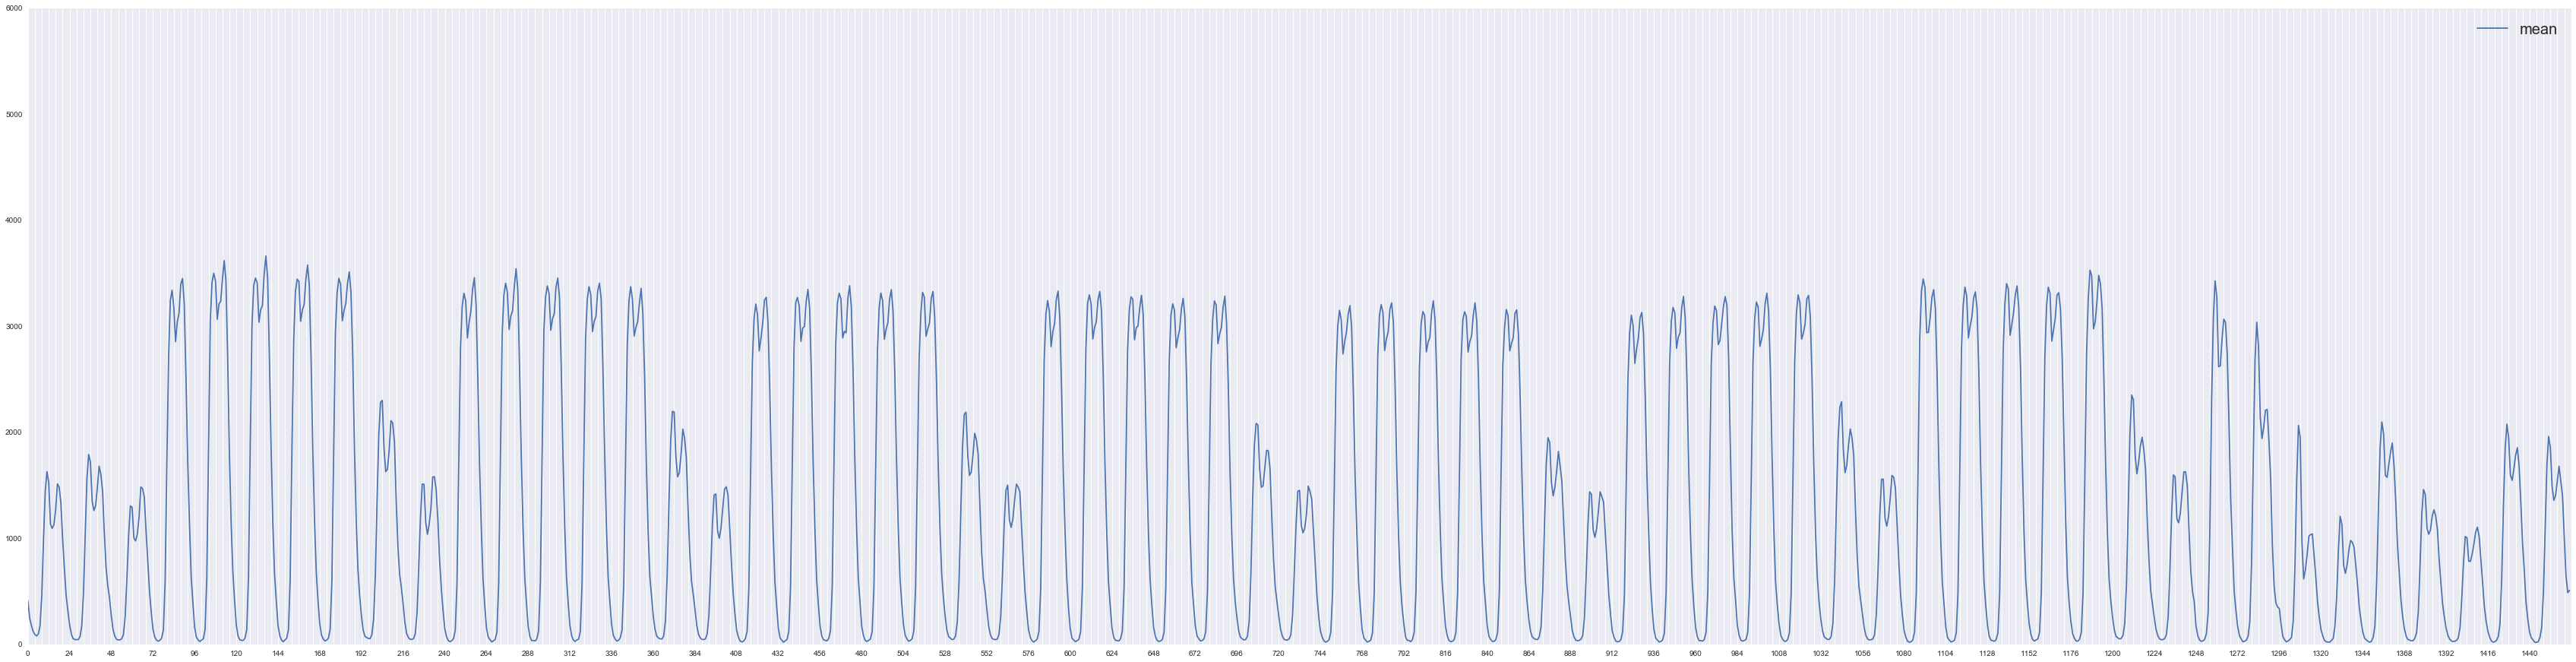

In [27]:
xpp, corr, linkage, mean = show_clustermap(cdr, "adjusted_callIn")
callin = draw_time_series(xpp, corr, linkage, 24*9, "callin_graph.png", -2000, 4000)

m = pd.DataFrame(mean)
m.index = range(0,1464)

x_range = 24*61

fig = plt.figure(figsize=(60,15))
ax = fig.add_subplot(1,1,1)
major_ticks = np.arange(0, x_range, 24)                                              
minor_ticks = np.arange(0, x_range, 4) 
ax.set_xticks(major_ticks)                                                       
ax.set_xticks(minor_ticks, minor=True)                                           
                           
# and a corresponding grid             
ax.grid(which='both')
ax.axis([0, x_range , 0, 6000])
ax.plot(m, label="mean")
ax.legend(prop={'size':20})
fig.savefig('mean_callin.png')

# CALL OUT

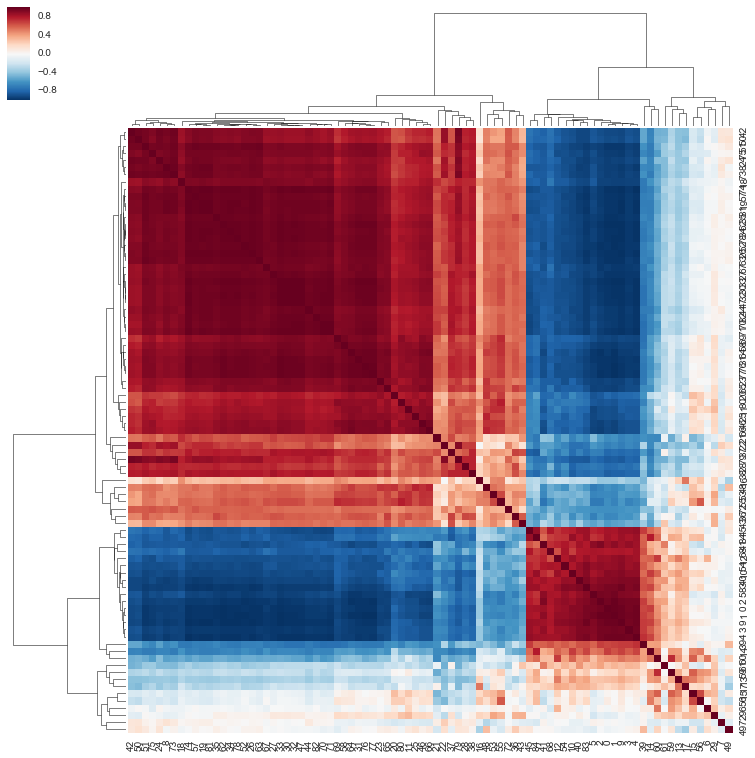

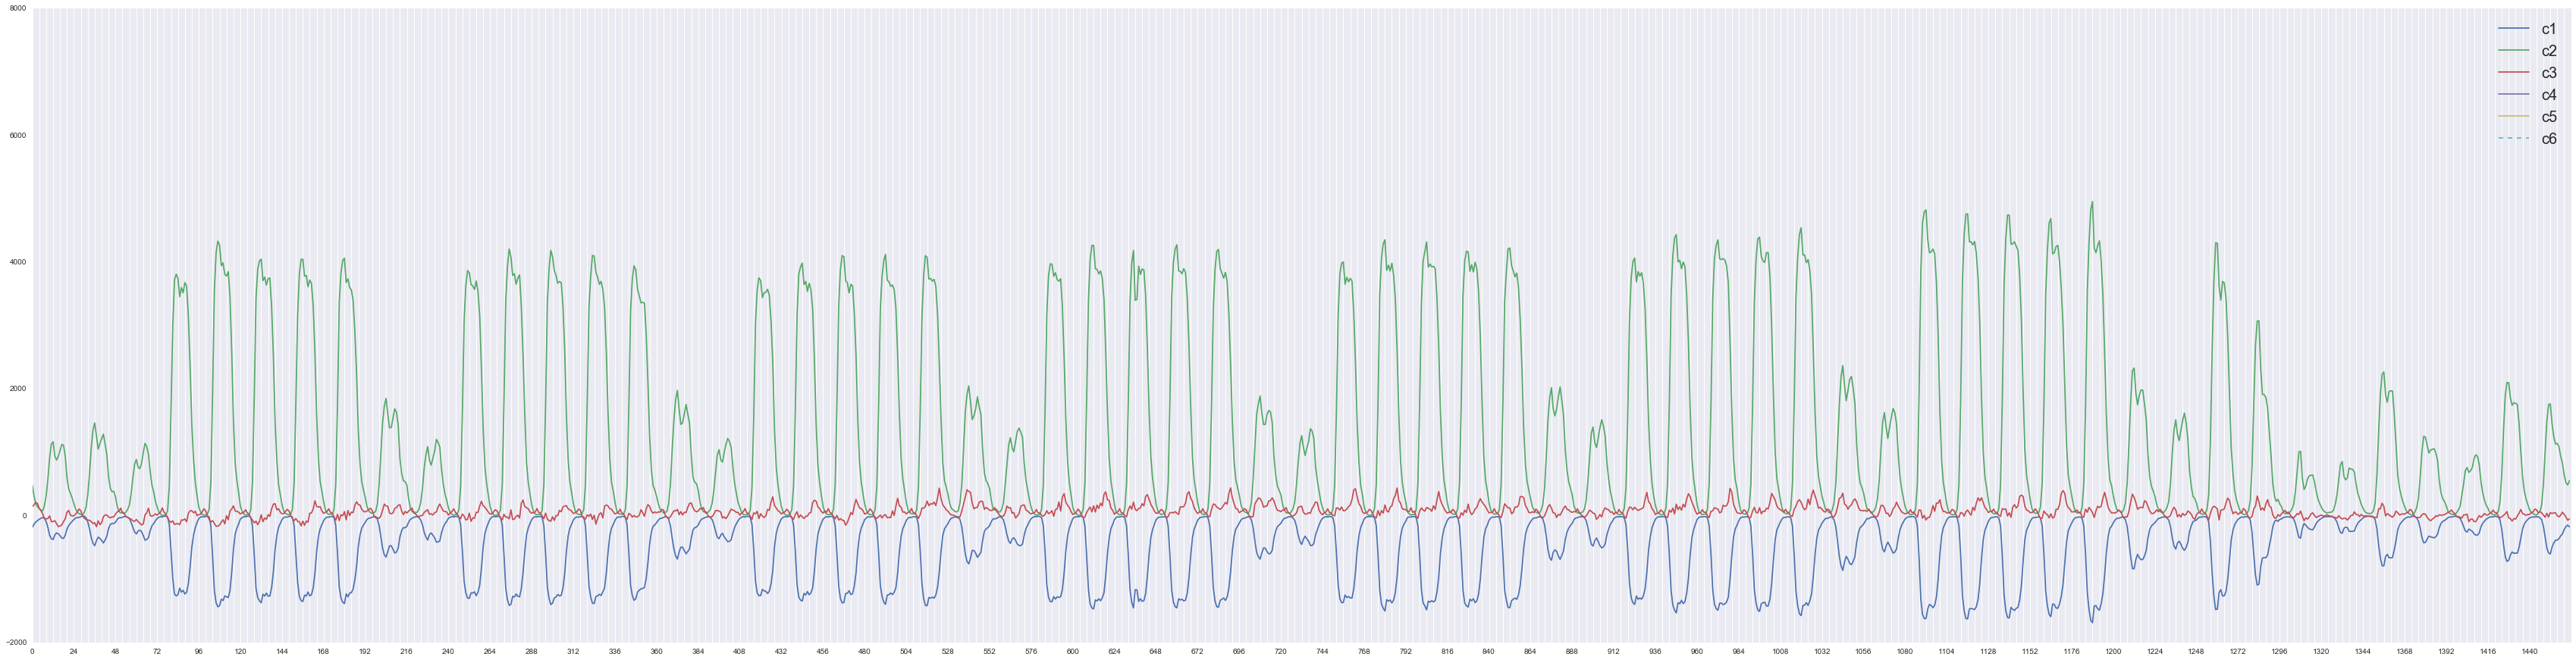

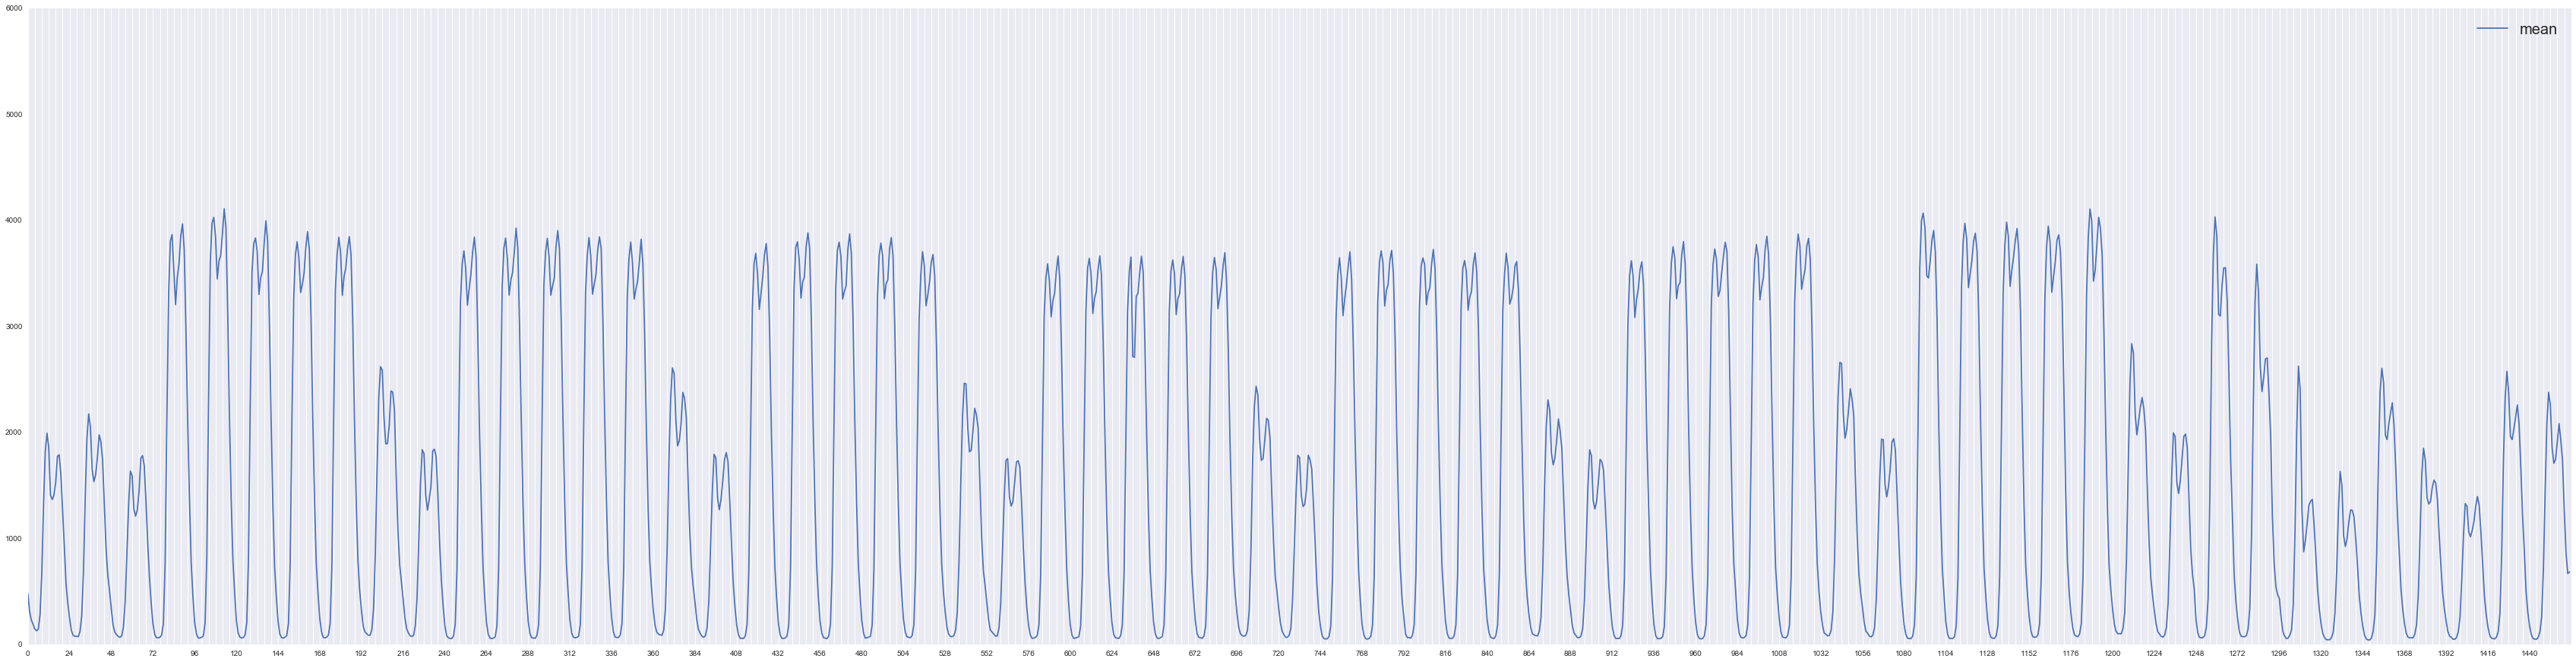

In [12]:
xpp, corr, linkage, mean = show_clustermap(cdr, "adjusted_callOut")
callout = draw_time_series(xpp, corr, linkage, 24*61, "callout_graph.png", -2000, 8000)

m = pd.DataFrame(mean)
m.index = range(0,1464)

x_range = 24*61

fig = plt.figure(figsize=(60,15))
ax = fig.add_subplot(1,1,1)
major_ticks = np.arange(0, x_range, 24)                                              
minor_ticks = np.arange(0, x_range, 4) 
ax.set_xticks(major_ticks)                                                       
ax.set_xticks(minor_ticks, minor=True)                                           
                           
# and a corresponding grid             
ax.grid(which='both')
ax.axis([0, x_range , 0, 6000])
ax.plot(m, label="mean")
ax.legend(prop={'size':20})
fig.savefig('mean_callout.png')

# SMS IN

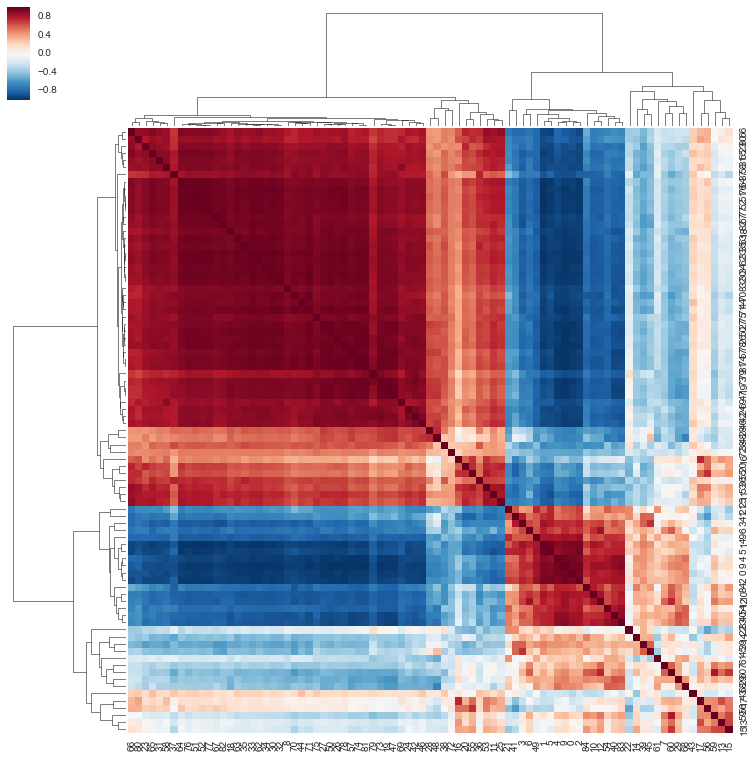

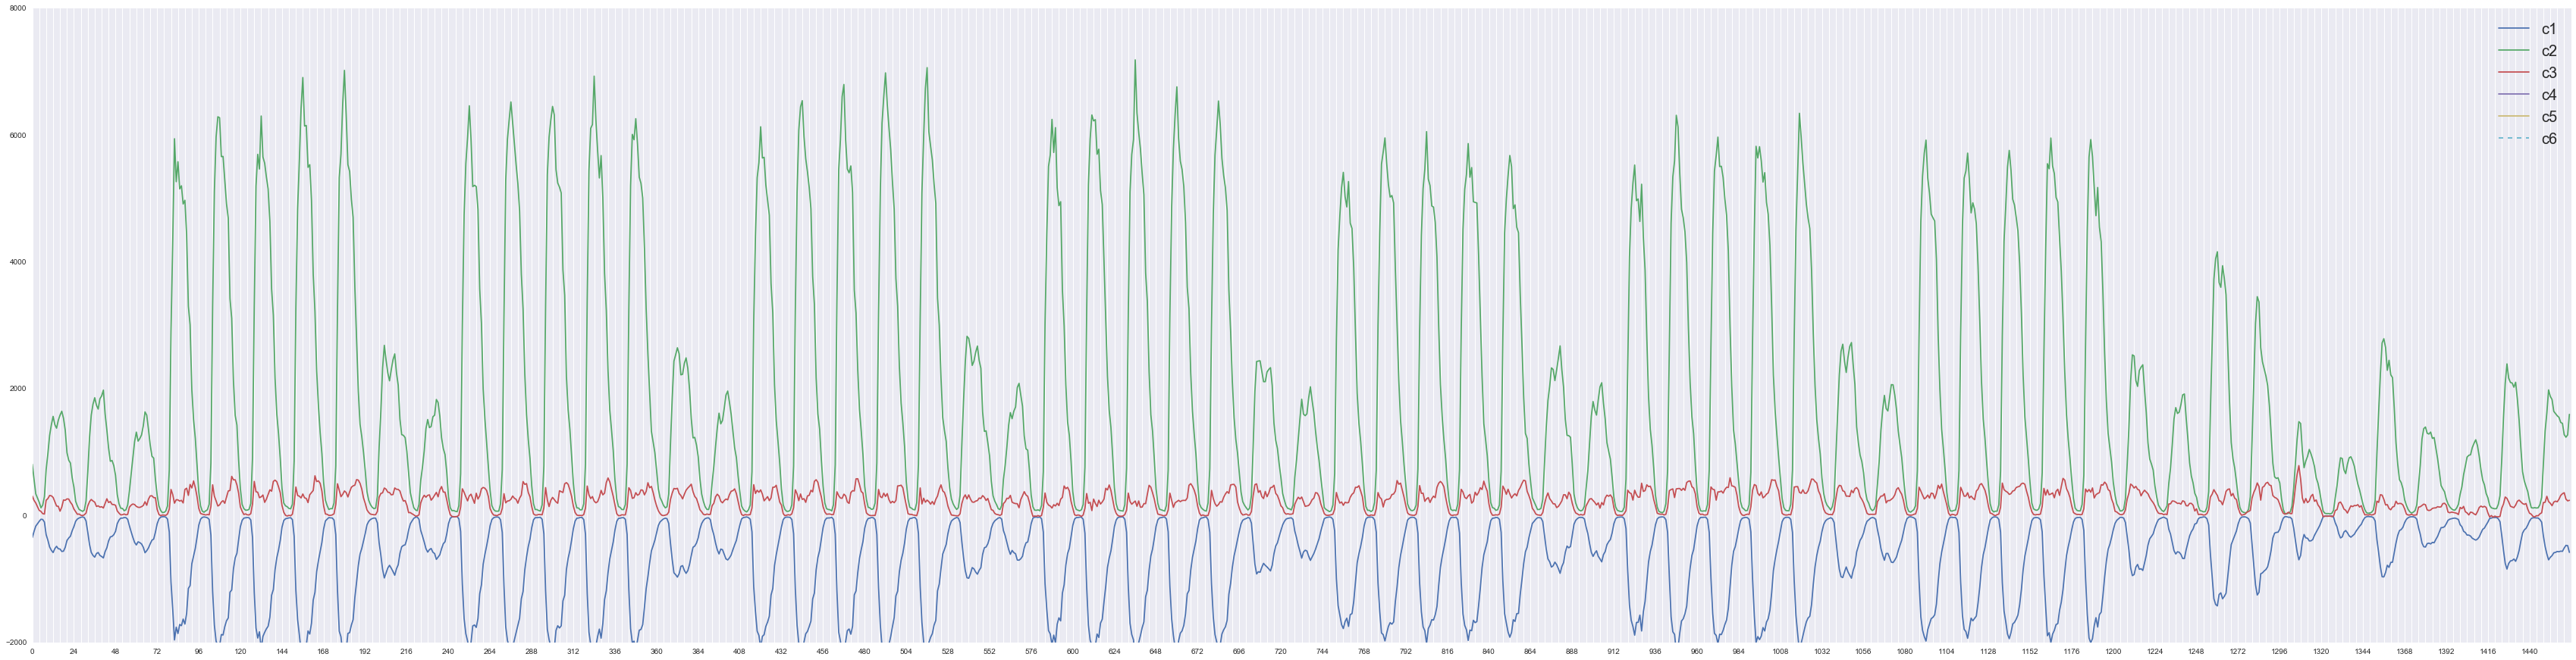

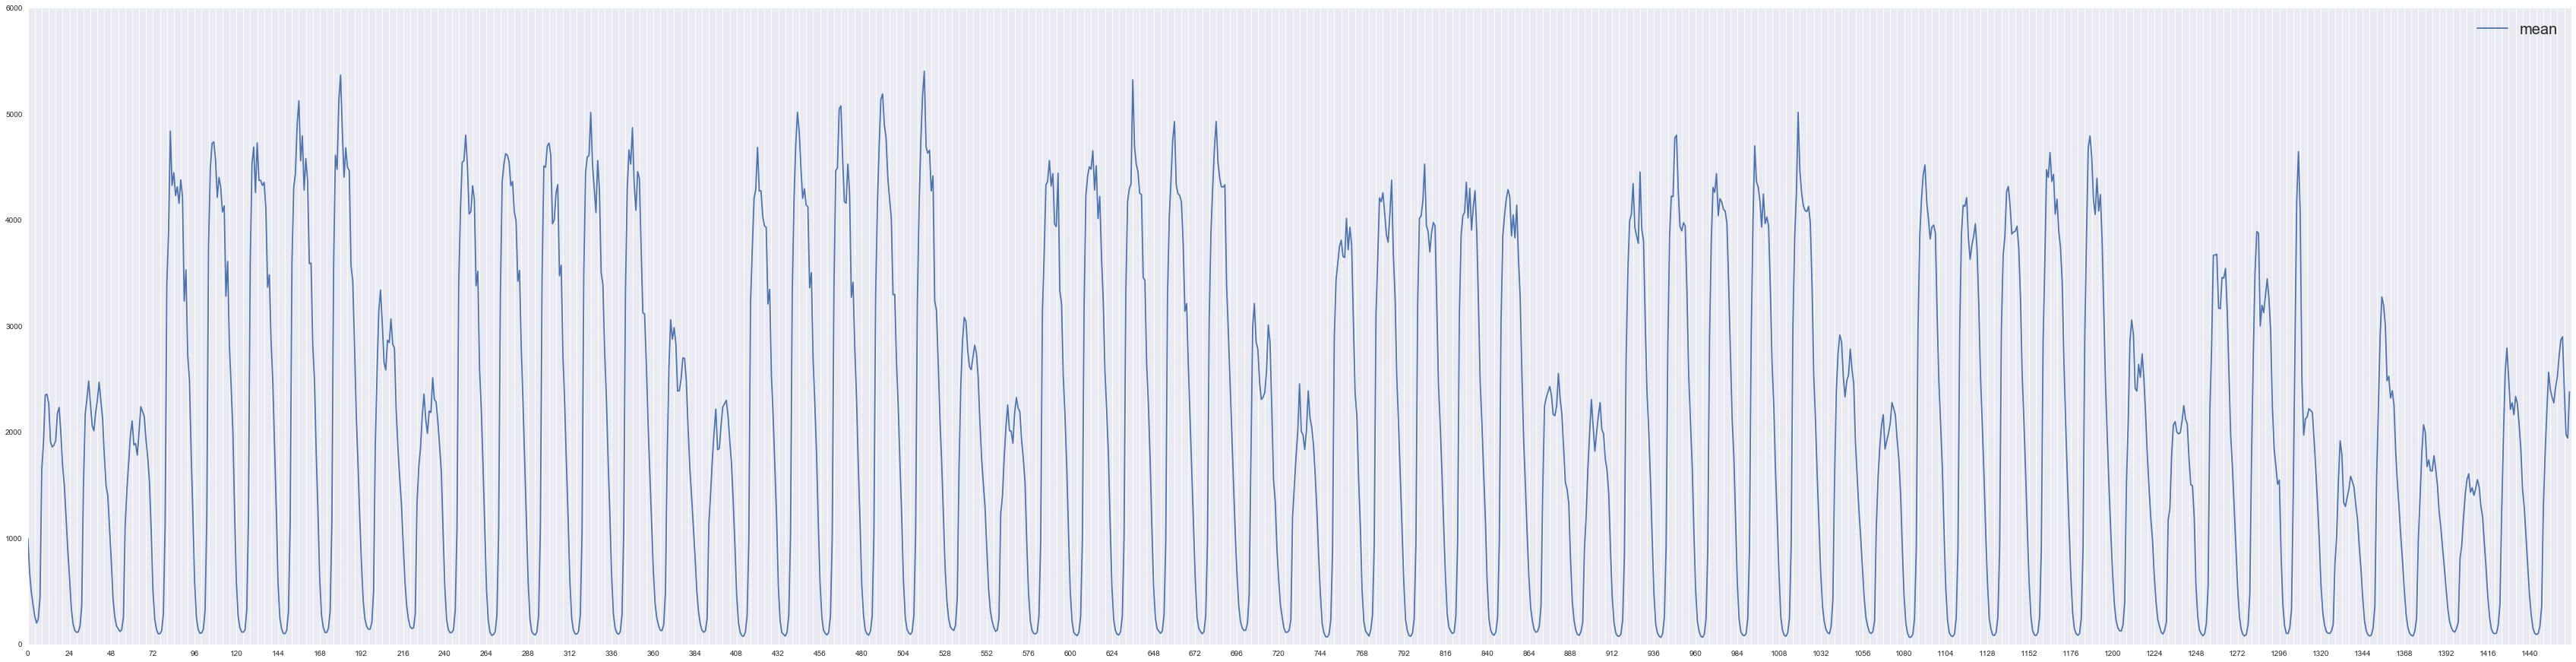

In [13]:
xpp, corr, linkage, mean = show_clustermap(cdr, "adjusted_smsIn")
smsin = draw_time_series(xpp, corr, linkage, 24*61, "smsin_graph.png", -2000, 8000)

m = pd.DataFrame(mean)
m.index = range(0,1464)

x_range = 24*61

fig = plt.figure(figsize=(60,15))
ax = fig.add_subplot(1,1,1)
major_ticks = np.arange(0, x_range, 24)                                              
minor_ticks = np.arange(0, x_range, 4) 
ax.set_xticks(major_ticks)                                                       
ax.set_xticks(minor_ticks, minor=True)                                           
                           
# and a corresponding grid             
ax.grid(which='both')
ax.axis([0, x_range , 0, 6000])
ax.plot(m, label="mean")
ax.legend(prop={'size':20})
fig.savefig('mean_smsin.png')

# SMS OUT

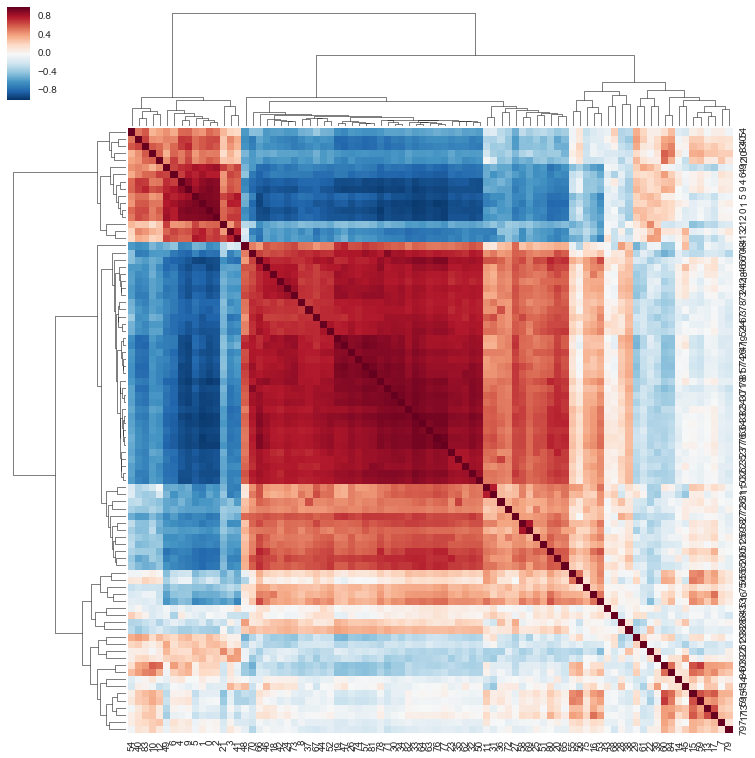

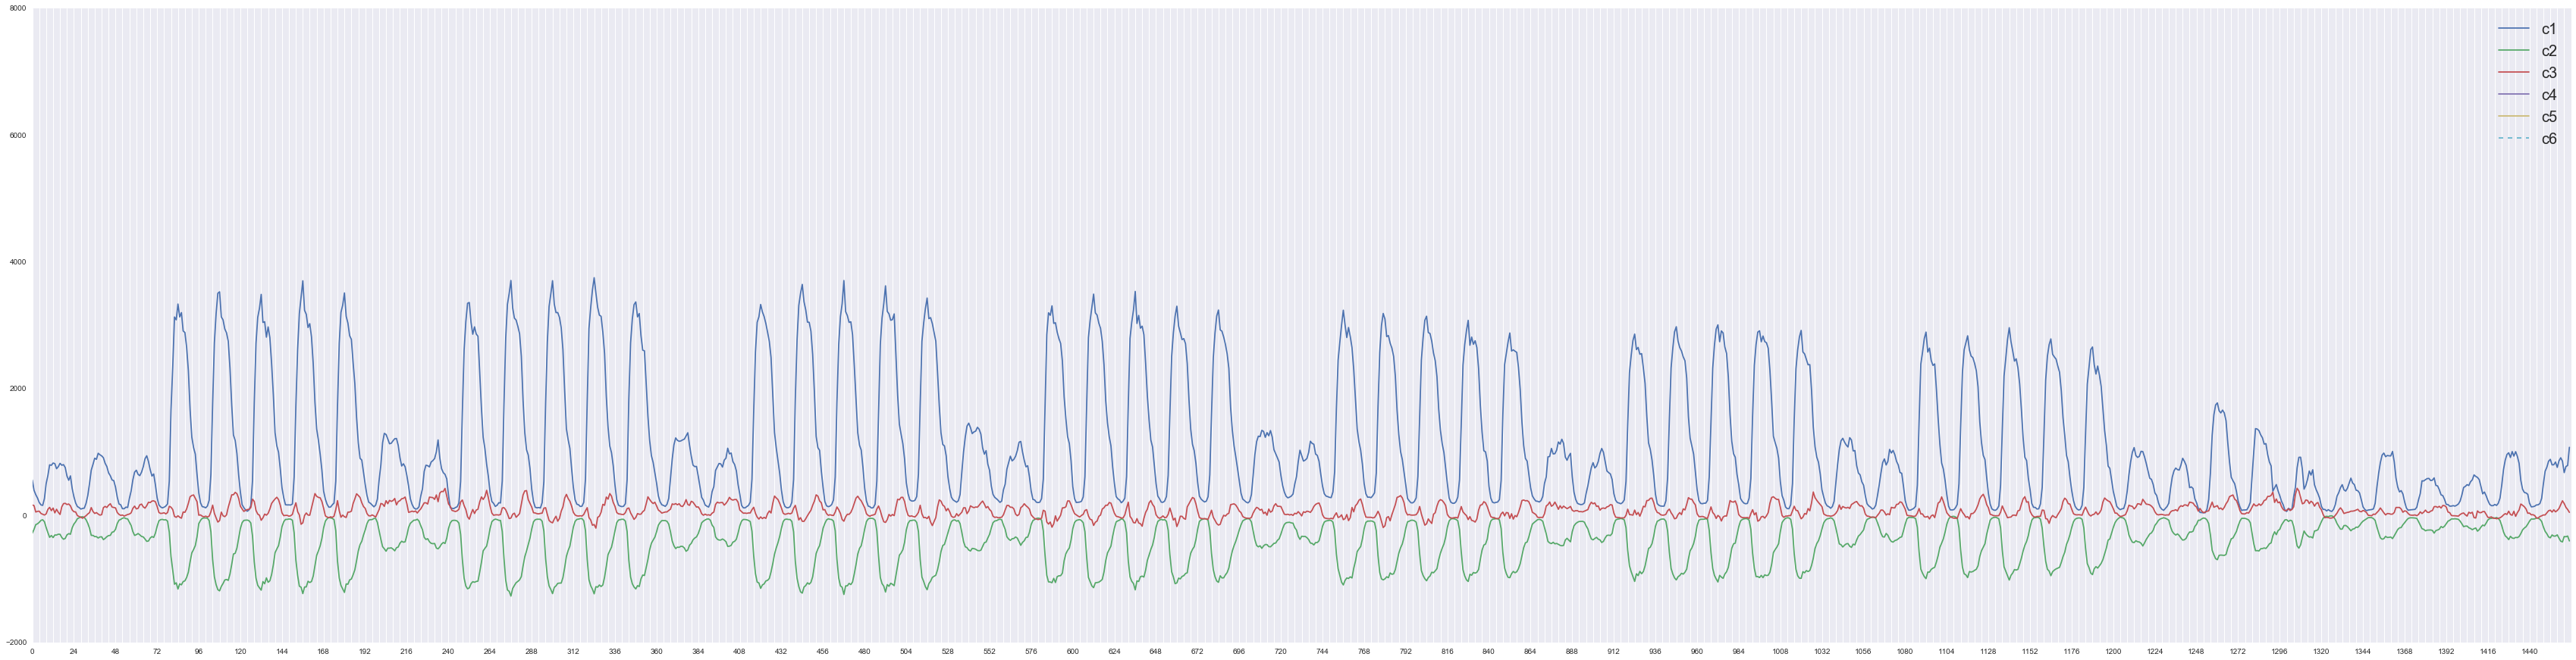

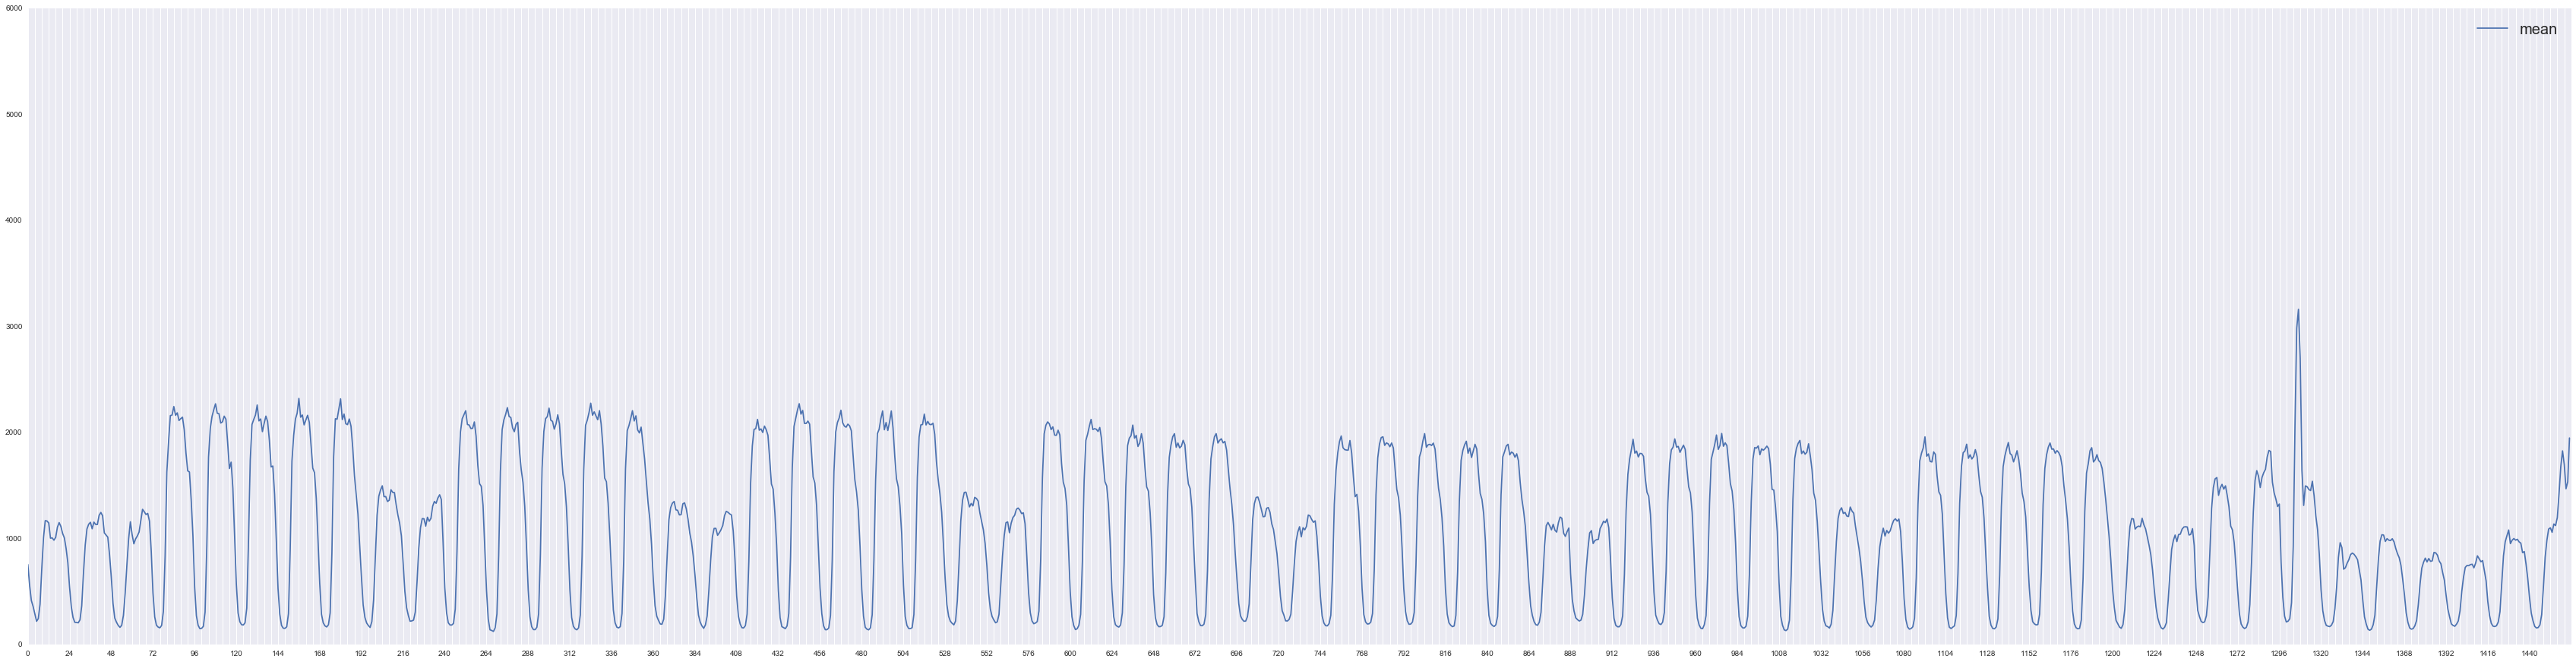

In [14]:
xpp, corr, linkage, mean = show_clustermap(cdr, "adjusted_smsOut")
smsout = draw_time_series(xpp, corr, linkage, 24*61, "smsout_graph.png", -2000, 8000)

m = pd.DataFrame(mean)
m.index = range(0,1464)

x_range = 24*61

fig = plt.figure(figsize=(60,15))
ax = fig.add_subplot(1,1,1)
major_ticks = np.arange(0, x_range, 24)                                              
minor_ticks = np.arange(0, x_range, 4) 
ax.set_xticks(major_ticks)                                                       
ax.set_xticks(minor_ticks, minor=True)                                           
                           
# and a corresponding grid             
ax.grid(which='both')
ax.axis([0, x_range , 0, 6000])
ax.plot(m, label="mean")
ax.legend(prop={'size':20})
fig.savefig('mean_smsout.png')

In [15]:
internet

cluster  region
cluster                 
2              2       1
2              2       2
2              2       3
2              2       4
2              2       5
2              2       6
2              2       7
2              2       8
1              1       9
2              2      10
2              2      11
1              1      12
2              2      13
1              1      14
2              2      15
1              1      16
1              1      17
1              1      18
1              1      19
1              1      20
1              1      21
3              3      22
3              3      23
1              1      24
1              1      25
1              1      26
1              1      27
1              1      28
1              1      29
2              2      30
...          ...     ...
1              1      56
1              1      57
1              1      58
1              1      59
2              2      60
2              2      61
3              3      62
1              1      63
1              1      64
1              1      65
1              1      66
1              1      67
1              1      68
1              1      69
1              1      70
1              1      71
1              1      72
1              1      73
1              1      74
1              1      75
1              1      76
1              1      77
1              1      78
1              1      79
1              1      80
1              1      81
1              1      82
1              1      83
2              2      84
2              2      85

[85 rows x 2 columns]

In [16]:
internet.index = internet.region
smsin.index = smsin.region
smsout.index = smsout.region
callin.index = callin.region
callout.index = callout.region



In [17]:
agg = pd.DataFrame(columns = ['internet', 'smsin', 'smsout', 'callin','callout'])

In [18]:
agg['smsin'] = smsin.cluster
agg['smsout'] = smsout.cluster
agg['callin'] = callin.cluster
agg['callout'] = callout.cluster
agg['internet'] = internet.cluster

In [19]:
agg.to_csv("intermediate.csv")

In [20]:
agg.T.to_csv("intermediateT.csv")